In [2]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

print(tf.__version__)

2.7.0


### Get our data

In [3]:
from getdata1 import *

# GET_csse_covid_19_daily_reports()
latest_data_global, prev_data_global = GET_csse_covid_19_daily_reports_my('global')
latest_data_us, prev_data_us = GET_csse_covid_19_daily_reports_my('us')

# GET_csse_covid_19_time_series()
time_series_covid19_confirmed_US, time_series_covid19_confirmed_global, time_series_covid19_deaths_US, time_series_covid19_deaths_global,time_series_covid19_recovered_global = GET_csse_covid_19_time_series_my()

# shanghai time series data
ts_shanghai_covid = GET_shanghai_data_my()

reading [cross sectional] data ......
finish reading
reading [cross sectional] data ......
finish reading
reading [time series] data ......
finish reading
reading [shanghai] data ......
finish reading


### Process data ready to use

In [4]:
from ipynb.fs.defs.process_analysis import ts_process_CHINA_my, ts_process_US_my, daily_process_my

In [5]:
ts_confirmed_CHINA_incre = ts_process_CHINA_my(time_series_covid19_confirmed_global)
ts_deaths_CHINA_incre = ts_process_CHINA_my(time_series_covid19_deaths_global)
ts_recovered_CHINA_incre = ts_process_CHINA_my(time_series_covid19_recovered_global)

ts_confirmed_US_incre = ts_process_US_my(time_series_covid19_confirmed_US,clip=False)
ts_deaths_US_incre = ts_process_US_my(time_series_covid19_deaths_US,death = True,clip=False)

latest_data_CHINA = daily_process_my(latest_data_global, country = 'China')
prev_data_CHINA = daily_process_my(prev_data_global, country = 'China')
latest_data_US = daily_process_my(latest_data_us, country = 'US')
prev_data_US = daily_process_my(prev_data_us, country = 'US')

First, take a look at New York data.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


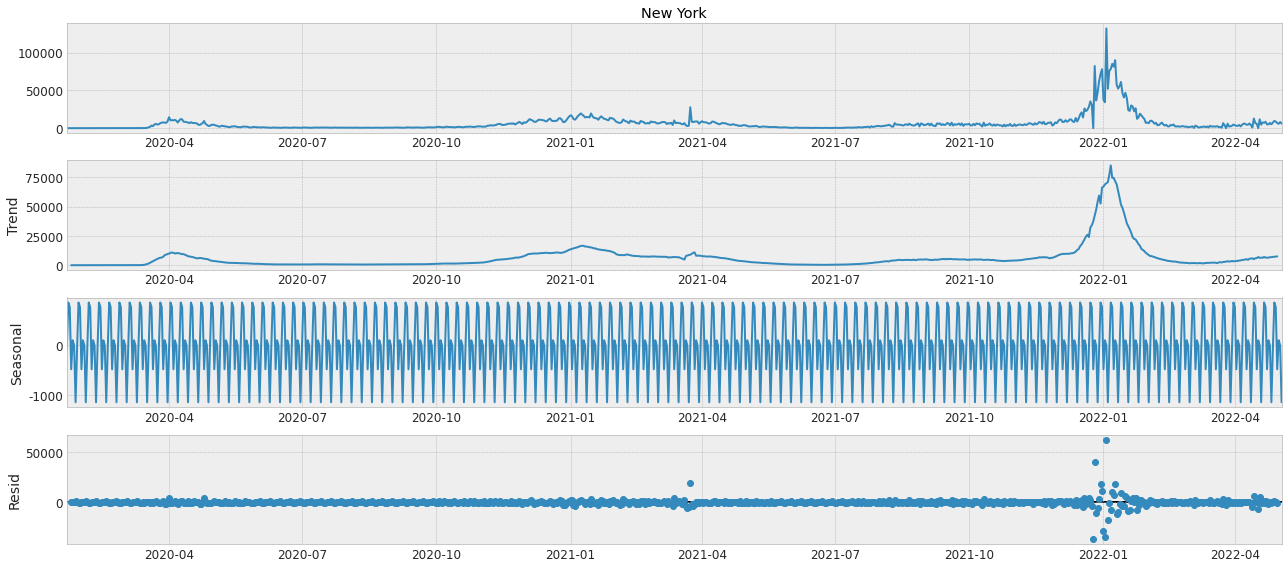

In [6]:
dcp1 = seasonal_decompose(ts_confirmed_US_incre['New York'],model='additive')

dcp1.plot()

plt.show()

In [7]:
df_reconstructed = pd.concat([dcp1.seasonal, dcp1.trend, dcp1.resid, dcp1.observed], axis=1)
df_reconstructed.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seasonal,trend,resid,actual_values
2020-01-22,-85.983897,NaN,NaN,0.0
2020-01-23,852.139590,NaN,NaN,0.0
2020-01-24,761.535474,NaN,NaN,0.0
2020-01-25,-481.008242,0.0,481.008242,0.0
2020-01-26,98.706176,0.0,-98.706176,0.0


##### use Unit Root tests to test for stationary
###### Augmented Dickey Fuller test (ADH Test)

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_reconstructed['actual_values'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.5572651340288983
p-value: 0.006632591462488981


From p-value, we can say that NY's data is stationary.

In [31]:
split_date = '2022-01-01'
df_train = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index < split_date,'New York']
df_test = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index >= split_date,'New York']
print(f"{len(df_train)} days of training data \n {len(df_test)} days of testing data ")

710 days of training data 
 123 days of testing data 


### auto SARIMA model

In [46]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

sarima_mdl = pm.auto_arima(df_train,start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonal=True, m=14, D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(sarima_mdl.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[14]             : AIC=13221.892, Time=3.72 sec
 ARIMA(0,1,0)(0,1,0)[14]             : AIC=13686.836, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[14]             : AIC=13321.426, Time=2.05 sec
 ARIMA(0,1,1)(0,1,1)[14]             : AIC=13276.665, Time=1.52 sec
 ARIMA(1,1,1)(0,1,1)[14]             : AIC=13220.301, Time=1.81 sec
 ARIMA(1,1,1)(0,1,0)[14]             : AIC=13269.935, Time=0.51 sec
 ARIMA(1,1,1)(0,1,2)[14]             : AIC=13222.062, Time=10.67 sec
 ARIMA(1,1,1)(1,1,0)[14]             : AIC=13229.053, Time=1.36 sec
 ARIMA(1,1,1)(1,1,2)[14]             : AIC=inf, Time=19.06 sec
 ARIMA(1,1,0)(0,1,1)[14]             : AIC=13306.409, Time=2.29 sec
 ARIMA(2,1,1)(0,1,1)[14]             : AIC=13199.819, Time=1.83 sec
 ARIMA(2,1,1)(0,1,0)[14]             : AIC=13254.406, Time=0.48 sec
 ARIMA(2,1,1)(1,1,1)[14]             : AIC=13201.395, Time=6.60 sec
 ARIMA(2,1,1)(0,1,2)[14]             : AIC=13201.572, Time=6.94 sec
 ARIMA(2,

resources:
http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/02/Lecture_03.pdf
https://www.machinelearningplus.com/time-series/time-series-analysis-python/
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/v

In [80]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in range(len(df_test)):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SARIMAX(temp_train['New York'],order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 14))
    model_fit = model.fit(disp=False,transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]

yhat_SARIMAX = pd.concat(yhat)

In [78]:
index = len(df_train)
yhat1 = list()
for t in range(len(df_test)):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'],order=(1,0,0))
    model_fit = model.fit(transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat1 = yhat1 + [predictions]

yhat_ARIMA1 = pd.concat(yhat1)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


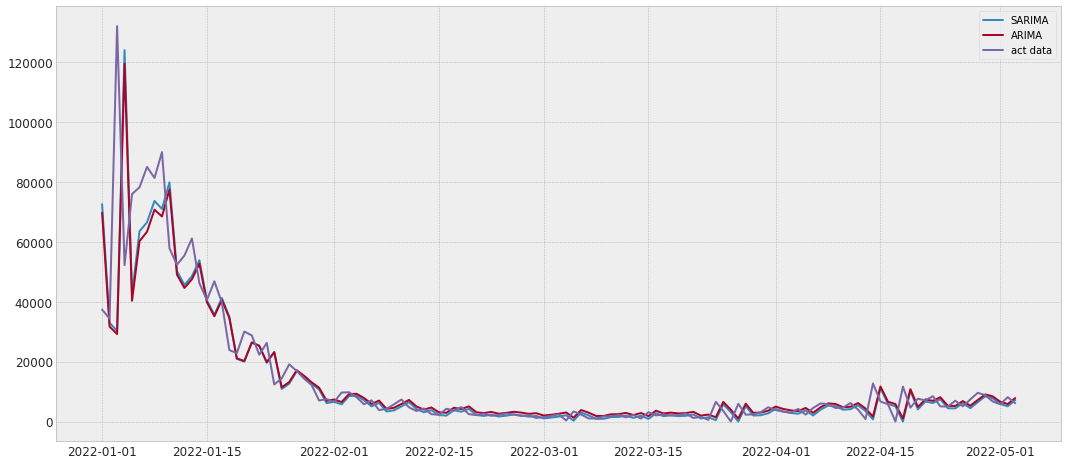

In [83]:
plt.plot(yhat_SARIMAX, label = 'SARIMA')
plt.plot(yhat_ARIMA1,label = 'ARIMA')
plt.plot(df_test,label = 'act data')
plt.legend()